# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

## Setup

We first import the LensKit components we need:

In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import als, item_knn as knn
from lenskit.metrics import topn as tnmetrics

And Pandas is very useful:

In [2]:
import pandas as pd

In [3]:
%matplotlib inline #only needed for IPython notebook
import matplotlib.pyplot as plt #if you are running your own script


## Loading Data

We're going to use the ML-100K data set:

In [4]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['user', 'item', 'rating', 'timestamp'])
print(ratings.head())

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Defining Algorithms

Let's set up two algorithms:

The first algorithm is an Item-item nearest-neighbor collaborative filtering [link](https://lkpy.lenskit.org/en/stable/knn.html)

The second algorithm is an alternating least square implementation of matrix factorization. [link](https://lkpy.lenskit.org/en/stable/mf.html#module-lenskit.algorithms.als)

algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure the quality of the recommendations

If memory is a concern, we can measure while generating, but we will not do that for now.

###Generating recommendations
Before we start generating recommendations, we will define a function that takes a name, an algorithm, a train set, and a test set as input and that generates recommendations as an output.

**Note:** before fitting the algorithm, we clone it.  Some algorithms misbehave when fit multiple times.

The code function looks like this:

In [6]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo) #see Note
    fittable.fit(train) #fit the algorithm on the training set
    users = test.user.unique() #look for unique users in the test set
    # the recommend function can merge rating values
    recs = batch.recommend(fittable, users, 100,
            topn.UnratedCandidates(train), test)
    # add the given name to the output algorithm
    recs['Algorithm'] = aname
    return recs

Now, we will loop over the data and the algorithms, and generate recommendations:

In [7]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

With the results in place, we can concatenate them into a single data frame:

In [8]:
all_recs = pd.concat(all_recs, ignore_index=True)
print(all_recs.head())

,item,score,user,rank,rating,Algorithm
0,603,4.742555,6,1,0.0,ItemItem
1,357,4.556866,6,2,4.0,ItemItem
2,1398,4.493086,6,3,0.0,ItemItem
3,611,4.477099,6,4,0.0,ItemItem
4,1449,4.454879,6,5,0.0,ItemItem


In [9]:
test_data = pd.concat(test_data, ignore_index=True)

#Measure the quality of the recommendations
To measure the quality of the recommendation we want to calculate the nDCG. This is a per-user metric, so let's compute it for each user.

However, there is a little nuance: the recommendation list does not contain the information needed to normalize the DCG. Specifically, the nDCG depends on _all_ the user's test items.

So we need to do three things:

1. Compute DCG of the recommendation lists.
2. Compute ideal DCGs for each test user
3. Combine and compute normalized versions

We do assume here that each user only appears once per algorithm. Since our crossfold method partitions users, this is fine.

In [10]:
user_dcg = all_recs.groupby(['Algorithm', 'user']).rating.apply(tnmetrics.dcg)
user_dcg = user_dcg.reset_index(name='DCG')
print(user_dcg.head())

,Algorithm,user,DCG
0,ALS,1,11.556574
1,ALS,2,7.383188
2,ALS,3,1.223253
3,ALS,4,0.000000
4,ALS,5,4.857249


In [11]:
ideal_dcg = tnmetrics.compute_ideal_dcgs(test)
print(ideal_dcg.head())

,user,ideal_dcg
0,4,16.946678
1,14,34.937142
2,15,25.770188
3,22,34.698538
4,23,41.289861


In [12]:
user_ndcg = pd.merge(user_dcg, ideal_dcg)
user_ndcg['nDCG'] = user_ndcg.DCG / user_ndcg.ideal_dcg
print(user_ndcg.head())

,Algorithm,user,DCG,ideal_dcg,nDCG
0,ALS,4,0.000000,16.946678,0.000000
1,ItemItem,4,0.000000,16.946678,0.000000
2,ALS,14,7.060065,34.937142,0.202079
3,ItemItem,14,7.218123,34.937142,0.206603
4,ALS,15,1.773982,25.770188,0.068839


Now we have nDCG values!

In [13]:
print(user_ndcg.groupby('Algorithm').nDCG.mean())

Algorithm
ALS         0.133029
ItemItem    0.104659
Name: nDCG, dtype: float64

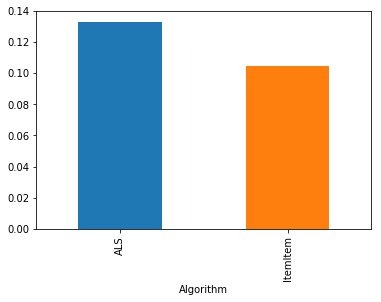

In [14]:
user_ndcg.groupby('Algorithm').nDCG.mean().plot.bar()